In [9]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import os

In [4]:
sc.set_figure_params(figsize=(5,5))

Read the processed data sets

In [5]:
hlca_smoker = sc.read_h5ad("data/step1_HLCA_smoker_processed.h5ad")
hlca_nonsmoker = sc.read_h5ad("data/step1_HLCA_nonsmoker_processed.h5ad")
combined_smoker = sc.read_h5ad("data/step1_combined_smoker_processed.h5ad")
combined_nonsmoker = sc.read_h5ad("data/step1_combined_nonsmoker_processed.h5ad")

/jet/home/qsong/.conda/envs/lung_aging/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/jet/home/qsong/.conda/envs/lung_aging/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


## Data Integration by mnnpy

In [6]:
from functools import reduce
import mnnpy

/jet/home/qsong/.conda/envs/lung_aging/lib/python3.9/site-packages/mnnpy/utils.py:30: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 1d, A), array(float32, 1d, A))
  dist[i, j] = np.dot(m[i], n[j])
/jet/home/qsong/.conda/envs/lung_aging/lib/python3.9/site-packages/mnnpy/utils.py:30: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 1d, A), array(float32, 1d, A))
  dist[i, j] = np.dot(m[i], n[j])
/jet/home/qsong/.conda/envs/lung_aging/lib/python3.9/site-packages/mnnpy/utils.py:205: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 1d, C), array(float32, 1d, A))
  scale = np.dot(working, grad)
/jet/home/qsong/.conda/envs/lung_aging/lib/python3.9/site-packages/mnnpy/utils.py:205: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 1d, C), array(float32, 1d, A))
  scale = np.dot(working, grad)
/jet/home/qsong/.conda/envs/lu

Get highly variable genes used for integration

In [7]:
sc.pp.highly_variable_genes(combined_smoker,inplace = True)
sc.pp.highly_variable_genes(hlca_smoker,inplace = True)
sc.pp.highly_variable_genes(combined_nonsmoker,inplace = True)
sc.pp.highly_variable_genes(hlca_nonsmoker,inplace = True)

### Integration 1: combined(smoker) -> HLCA(smoker)

In [8]:
hvg = np.intersect1d(combined_smoker.var.index[combined_smoker.var['highly_variable']],
               hlca_smoker.var.index[hlca_smoker.var['highly_variable']]
              )

comm_genes = np.intersect1d(combined_smoker.var_names, hlca_smoker.var_names)
combined_smoker = combined_smoker[:,comm_genes].copy()
hlca_smoker = hlca_smoker[:,comm_genes].copy()
combined_smoker.obs = combined_smoker.obs.loc[:,['dataset']]
hlca_smoker.obs = hlca_smoker.obs.loc[:,['dataset']]
ann1 = combined_smoker[combined_smoker.obs["dataset"] == "Carraro",].copy()
ann2 = combined_smoker[combined_smoker.obs["dataset"] == "Kaminski",].copy()

corrected = mnnpy.mnn_correct(hlca_smoker, ann1, ann2,
                              var_subset = hvg,
                              batch_categories = ["HLCA","Carraro","Kaminski"],
                              n_jobs = 60
                             )

Performing cosine normalization...
Starting MNN correct iteration. Reference batch: 0
Step 1 of 2: processing batch 1
  Looking for MNNs...
  Computing correction vectors...
  Adjusting variance...
  Applying correction...
Step 2 of 2: processing batch 2
  Looking for MNNs...
  Computing correction vectors...
  Adjusting variance...
  Applying correction...
MNN correction complete. Gathering output...
Packing AnnData object...


/jet/home/qsong/.conda/envs/lung_aging/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


Done.


How well is the integration?

/jet/home/qsong/.conda/envs/lung_aging/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/jet/home/qsong/.conda/envs/lung_aging/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


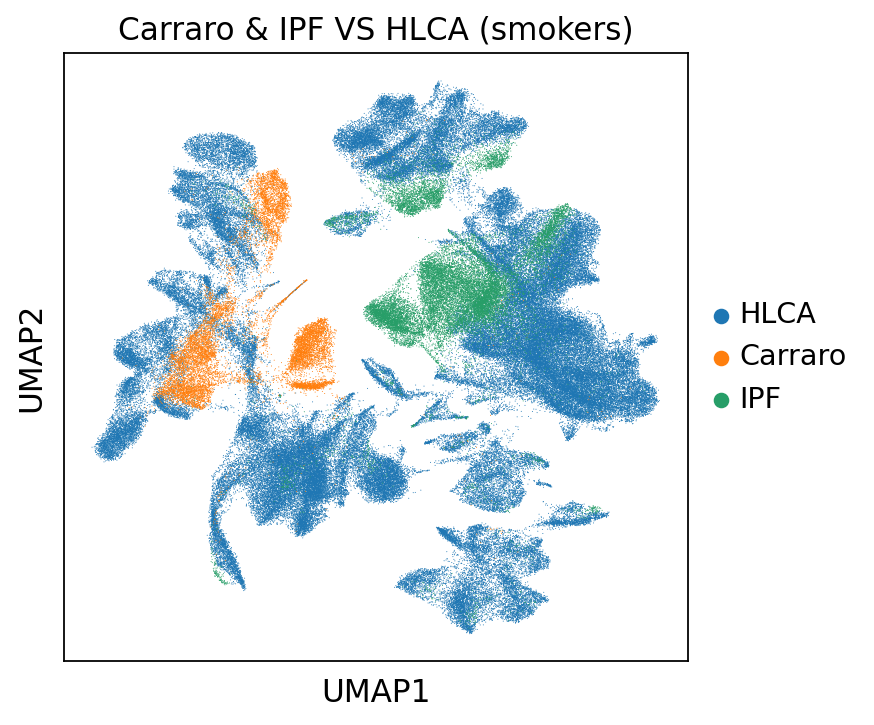

In [17]:
bdata = corrected[0][:, hvg]
#bdata = bdata[:, hvg]
bdata.obs.replace("Kaminski","IPF",inplace = True)
sc.pp.scale(bdata)
sc.pp.neighbors(bdata)
sc.tl.umap(bdata)
sc.pl.umap(bdata, color='batch',title="Carraro & IPF VS HLCA (smokers)",size=0.8)

Save the corrected data

In [12]:
if not os.path.isdir("results/correction_mnnpy"):
    os.mkdir("results/correction_mnnpy")
corrected[0].write_h5ad("results/correction_mnnpy/corrected_combined_smoker.h5ad")

### Integration 2: combined(nonsmoker) -> HLCA(nonsmoker)

In [12]:
hvg = np.intersect1d(combined_nonsmoker.var.index[combined_nonsmoker.var['highly_variable']],
               hlca_nonsmoker.var.index[hlca_nonsmoker.var['highly_variable']]
              )

comm_genes = np.intersect1d(combined_nonsmoker.var_names, hlca_nonsmoker.var_names)
combined_nonsmoker = combined_nonsmoker[:,comm_genes]
hlca_nonsmoker = hlca_nonsmoker[:,comm_genes]
combined_nonsmoker.obs = combined_nonsmoker.obs.loc[:,['dataset']]
hlca_nonsmoker.obs = hlca_nonsmoker.obs.loc[:,['dataset']]
ann1 = combined_nonsmoker[combined_nonsmoker.obs["dataset"] == "Carraro",].copy()
ann2 = combined_nonsmoker[combined_nonsmoker.obs["dataset"] == "Kaminski",].copy()

corrected_nonsmoker = mnnpy.mnn_correct(hlca_nonsmoker, ann1, ann2,
                              var_subset = hvg,
                              batch_categories = ["HLCA","Carraro","Kaminski"],
                              n_jobs = 60
                             )

Performing cosine normalization...
Starting MNN correct iteration. Reference batch: 0
Step 1 of 2: processing batch 1
  Looking for MNNs...
  Computing correction vectors...
  Adjusting variance...
  Applying correction...
Step 2 of 2: processing batch 2
  Looking for MNNs...
  Computing correction vectors...
  Adjusting variance...
  Applying correction...
MNN correction complete. Gathering output...
Packing AnnData object...


/jet/home/qsong/.conda/envs/lung_aging/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


Done.


How well is the integration?

/jet/home/qsong/.conda/envs/lung_aging/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/jet/home/qsong/.conda/envs/lung_aging/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


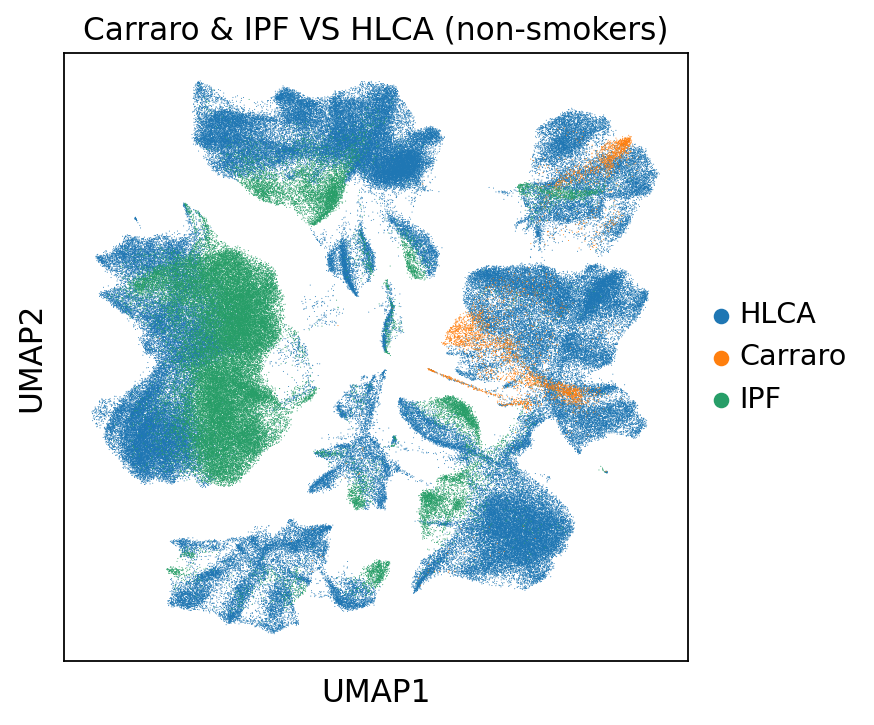

In [23]:
bdata = corrected_nonsmoker[0][:, hvg]
#bdata = bdata[:,hvg]
bdata.obs.replace("Kaminski","IPF",inplace = True)
sc.pp.scale(bdata)
sc.pp.neighbors(bdata)
sc.tl.umap(bdata)
sc.pl.umap(bdata, color='batch',title="Carraro & IPF VS HLCA (non-smokers)",size=0.8)

Save the corrected data

In [14]:
if not os.path.isdir("results/correction_mnnpy"):
    os.mkdir("results/correction_mnnpy")
corrected_nonsmoker[0].write_h5ad("correction_mnnpy/corrected_combined_nonsmoker.h5ad")